In [3]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# 1. Datengenerierung
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, 50)  # Eingabedaten
true_amplitude = 1.0
true_frequency = 1.0
true_phase = 0.5
true_offset = 0.0
y_true = true_amplitude * np.sin(true_frequency * x + true_phase) + true_offset
y_obs = y_true + np.random.normal(scale=0.2, size=len(x))  # Hinzufügen von Rauschen

with pm.Model() as model:
    # Priors für die Parameter
    amplitude = pm.TruncatedNormal("amplitude", mu=1.0, sigma=0.2, lower = 0)  # Engerer Prior für Amplitude
    frequency = pm.TruncatedNormal("frequency", mu=1.0, sigma=1, lower = 0)  # Engerer Prior für Frequenz
    #phase = pm.Uniform("phase", lower=0, upper=2 * np.pi)  # Phase bleibt unverändert
    phase = pm.TruncatedNormal("phase", mu=0.5, sigma=1, lower = 0, upper = 10* np.pi)  # Engerer Prior für Phase
    offset = pm.Normal("offset", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.2)  # Engerer Prior für Rauschen

    #uniform priors
    #amplitude = pm.Uniform("amplitude", lower = 0, upper = 3)  # Uniformer Prior für Amplitude
    #frequency = pm.Uniform("frequency", lower = 0, upper = 3)  # Uniformer Prior für Frequenz
    #phase = pm.Uniform("phase", lower = 0, upper = 8 * np.pi)  # Uniformer Prior für Phase  
    #offset = pm.Uniform("offset", lower = -3, upper = 3)  # Uniformer Prior für Offset
    #sigma = pm.Uniform("sigma", lower = 0, upper = 1)  # Uniformer Prior für Rauschen
    
    # Modell: Sinusfunktion
    mu = amplitude * pm.math.sin(frequency * x + phase) + offset
    
    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    # Sampling
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, chains = 20)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 4 jobs)
NUTS: [amplitude, frequency, phase, offset, sigma]


Output()

Sampling 20 chains for 1_000 tune and 1_000 draw iterations (20_000 + 20_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


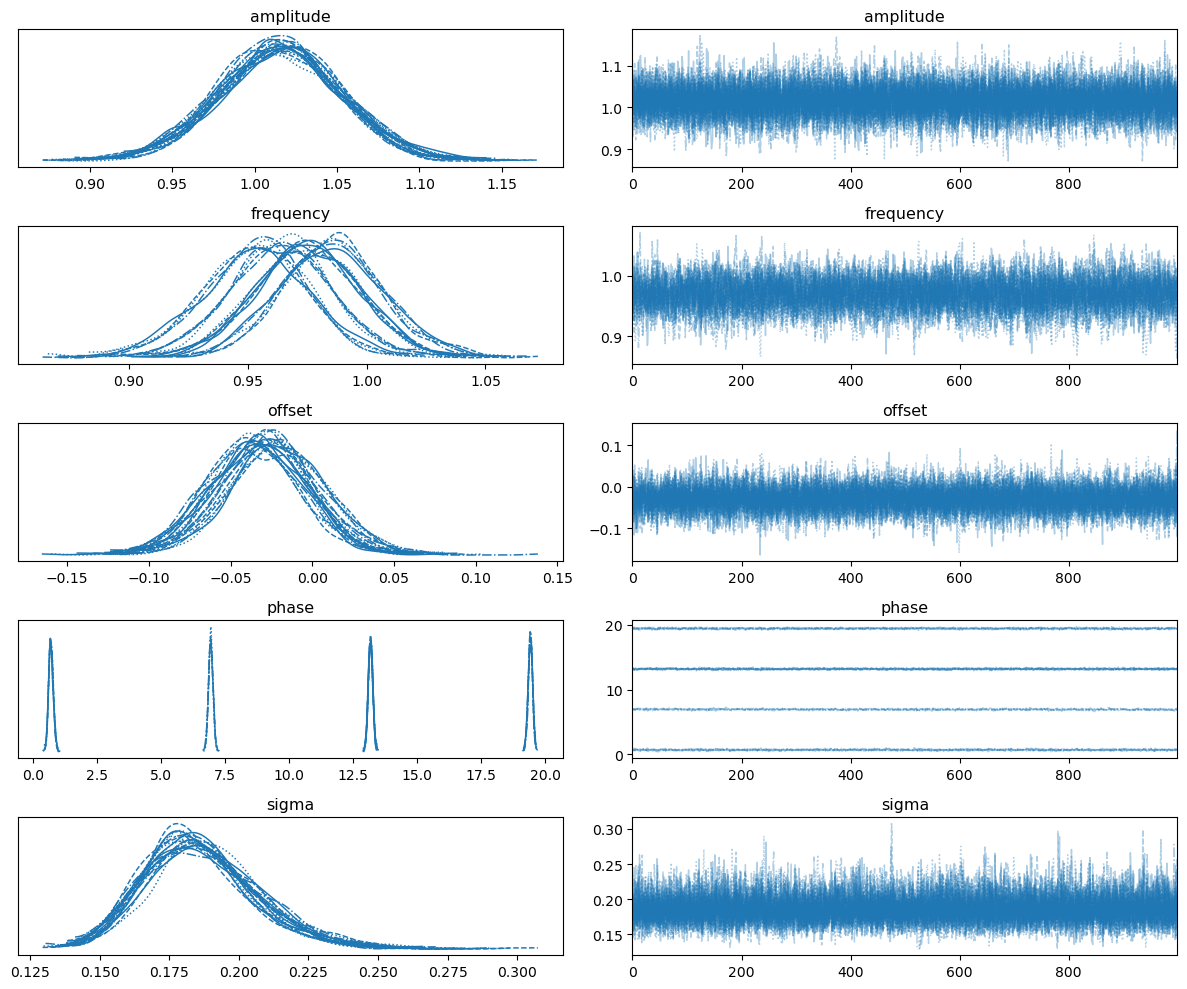

In [4]:

# Ergebnisse visualisieren
az.plot_trace(trace)
plt.tight_layout()
plt.show()


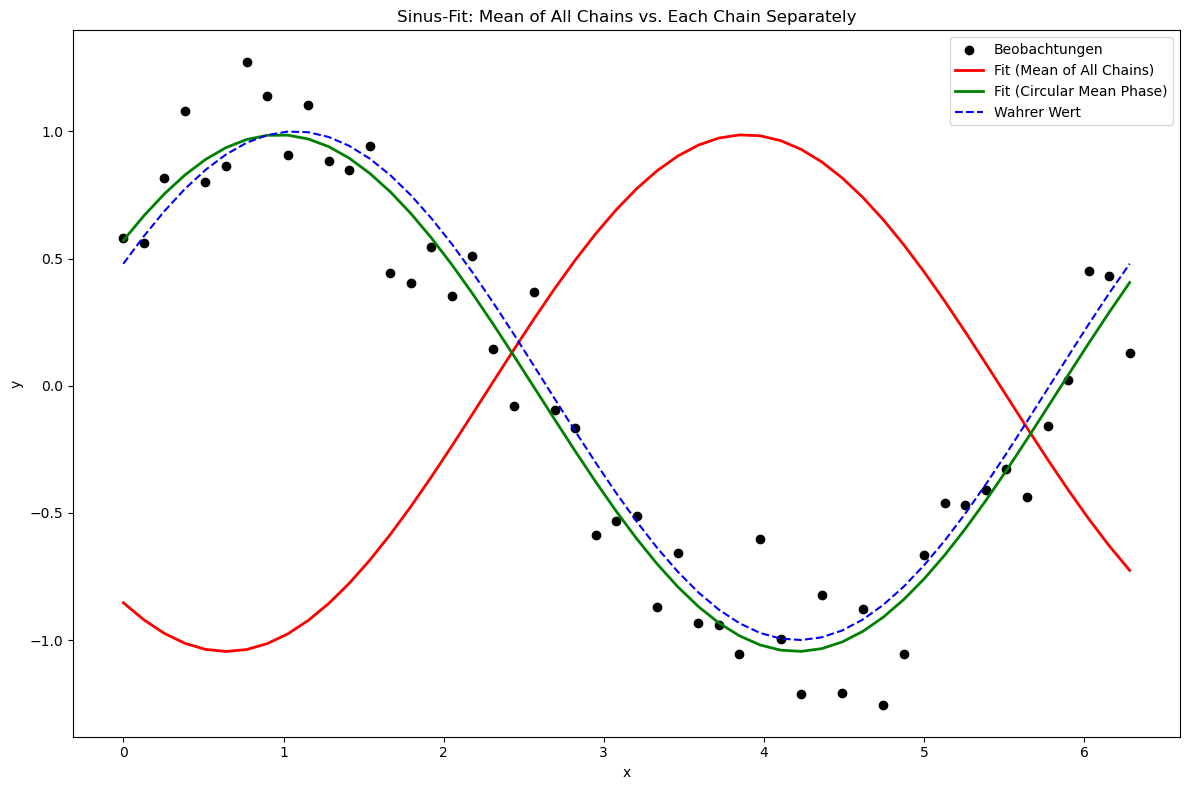

In [5]:
posterior_samples = trace.posterior

# Normalize phase values to [0, 2π]
phase_samples = posterior_samples.phase.values % (2 * np.pi)

# Compute the circular mean for the phase
sin_mean = np.mean(np.sin(phase_samples), axis=(0, 1))  # Mean over chains and draws
cos_mean = np.mean(np.cos(phase_samples), axis=(0, 1))  # Mean over chains and draws
circular_phase_mean = np.arctan2(sin_mean, cos_mean) % (2 * np.pi)  # Circular mean

# Compute mean for other parameters
amplitude_mean = posterior_samples.amplitude.mean(dim=["chain", "draw"]).item()
frequency_mean = posterior_samples.frequency.mean(dim=["chain", "draw"]).item()
offset_mean = posterior_samples.offset.mean(dim=["chain", "draw"]).item()
phase_mean = posterior_samples.phase.mean(dim=["chain", "draw"]).item()

# Single fit line with circular phase mean
y_fit_mean_adjusted = amplitude_mean * np.sin(frequency_mean * x + circular_phase_mean) + offset_mean
# Single fit line with regular phase mean
y_fit_mean = amplitude_mean * np.sin(frequency_mean * x + phase_mean) + offset_mean

# 5. Fitted lines for each chain
num_chains = posterior_samples.sizes["chain"]

# Plot both approaches
plt.figure(figsize=(12, 8))

# Scatter plot of observations
plt.scatter(x, y_obs, label="Beobachtungen", color="black")

# Old way: Plot the mean fit across all chains
plt.plot(x, y_fit_mean, label="Fit (Mean of All Chains)", color="red", linewidth=2)

# Fit with circular phase mean
plt.plot(x, y_fit_mean_adjusted, label="Fit (Circular Mean Phase)", color="green", linewidth=2)

# Current way: Plot the fitted lines for each chain
for chain in range(num_chains):
    chain_amplitude = posterior_samples.amplitude.isel(chain=chain).mean(dim="draw").item()
    chain_frequency = posterior_samples.frequency.isel(chain=chain).mean(dim="draw").item()
    chain_phase = posterior_samples.phase.isel(chain=chain).mean(dim="draw").item()
    chain_offset = posterior_samples.offset.isel(chain=chain).mean(dim="draw").item()
    
    # Generate fitted line for the chain
    y_fit_chain = chain_amplitude * np.sin(chain_frequency * x + chain_phase) + chain_offset
    #plt.plot(x, y_fit_chain, label=f"Fit Chain {chain + 1}", linestyle="--", alpha=0.8)

# Plot the true function
plt.plot(x, y_true, label="Wahrer Wert", linestyle="dashed", color="blue")

# Finalize the plot
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sinus-Fit: Mean of All Chains vs. Each Chain Separately")
plt.tight_layout()
plt.show()


In [36]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data